# Multi-view vs Single-view Spherical KMeans

Note, this tutorial compares performance against the SphericalKMeans function from the spherecluster package which is not a installed dependency of mvlearn.

In [3]:
import numpy as np
from numpy.random import multivariate_normal
from mvlearn.cluster.mv_spherical_kmeans import MultiviewSphericalKMeans
from spherecluster import SphericalKMeans, sample_vMF
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d, Axes3D
import warnings
warnings.filterwarnings('ignore')

##### A function to generate 2 views of data for 2 classes

This function takes parameters for means, kappas (concentration parameter), and number of samples for class and generates data based on those parameters. The underlying probability distribution of the data is a von Mises-Fisher distribution. 

In [4]:
def create_data(seed, vmeans, vkappas, num_per_class=500):
    
    np.random.seed(seed)
    data = [[],[]]
    for view in range(2):
        for comp in range(len(vmeans[0])):
            comp_samples = sample_vMF(vmeans[view][comp],
                        vkappas[view][comp], num_per_class)
            data[view].append(comp_samples)
    for view in range(2):
        data[view] = np.vstack(data[view])
        
    labels = list()
    for ind in range(len(vmeans[0])):
        labels.append(ind * np.ones(num_per_class,))
    
    labels = np.concatenate(labels)
    
    return data, labels

##### Creating a function to display data and the results of clustering

The following function plots both views of data given a dataset and corresponding labels.

In [20]:
def display_plots(pre_title, data, labels):
    plt.ion()
    # plot the views
    plt.figure()
    fig = plt.figure(figsize=(14, 10))
    for v in range(2):
        ax = fig.add_subplot(
            1, 2, v+1, projection='3d', 
            xlim=[-1.1, 1.1], ylim=[-1.1, 1.1], zlim=[-1.1, 1.1]
        )
        ax.scatter(data[v][:, 0], data[v][:, 1], data[v][:, 2], c=labels, s=8)
        ax.set_title(pre_title + ' View ' + str(v))
        plt.axis('off')
    
    plt.show()

##### Creating a function to perform both single-view and multi-view spherical kmeans clustering

In the following function, we will perform single-view spherical kmeans clustering on the two views separately and on them concatenated together. We also perform multi-view clustering using the multi-view algorithm. We will also compare the performance of multi-view and single-view versions of the spherical kmeans clustering. We will evaluate the purity of the resulting clusters from each algorithm with respect to the class labels using the normalized mutual information metric.

In [6]:
def perform_clustering(seed, m_data, labels, n_clusters):
    #################Single-view spherical kmeans clustering#####################
    # Cluster each view separately
    s_kmeans = SphericalKMeans(n_clusters=n_clusters, random_state=seed, n_init=100)
    s_clusters_v1 = s_kmeans.fit_predict(m_data[0])
    s_clusters_v2 = s_kmeans.fit_predict(m_data[1])

    # Concatenate the multiple views into a single view
    s_data = np.hstack(m_data)
    s_clusters = s_kmeans.fit_predict(s_data)

    # Compute nmi between true class labels and single-view cluster labels
    s_nmi_v1 = nmi_score(labels, s_clusters_v1)
    s_nmi_v2 = nmi_score(labels, s_clusters_v2)
    s_nmi = nmi_score(labels, s_clusters)
    print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
    print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
    print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

    #################Multi-view spherical kmeans clustering######################

    # Use the MultiviewKMeans instance to cluster the data
    m_kmeans = MultiviewSphericalKMeans(n_clusters=n_clusters, n_init=100, random_state=seed)
    m_clusters = m_kmeans.fit_predict(m_data)

    # Compute nmi between true class labels and multi-view cluster labels
    m_nmi = nmi_score(labels, m_clusters)
    print('Multi-view NMI Score: {0:.3f}\n'.format(m_nmi))
    
    return m_clusters

##### General experimentation procedures

For each of the experiments below, we run both single-view spherical kmeans clustering and multi-view spherical kmeans clustering. For evaluating single-view performance, we run the algorithm on each view separately as well as all views concatenated together. We evalaute performance using normalized mutual information, which is a measure of cluster purity with respect to the true labels. For both algorithms, we use an n_init value of 100, which means that we run each algorithm across 100 random cluster initializations and select the best clustering results with respect to cluster inertia.

## Performance when cluster components in both views are well separated
As we can see, multi-view kmeans clustering performs about as well as single-view spherical kmeans clustering for the concatenated views, and single-view spherical kmeans clustering for view 1.

Single-view View 1 NMI Score: 0.906

Single-view View 2 NMI Score: 0.920

Single-view Concatenated NMI Score: 1.000

Multi-view NMI Score: 1.000



<Figure size 432x288 with 0 Axes>

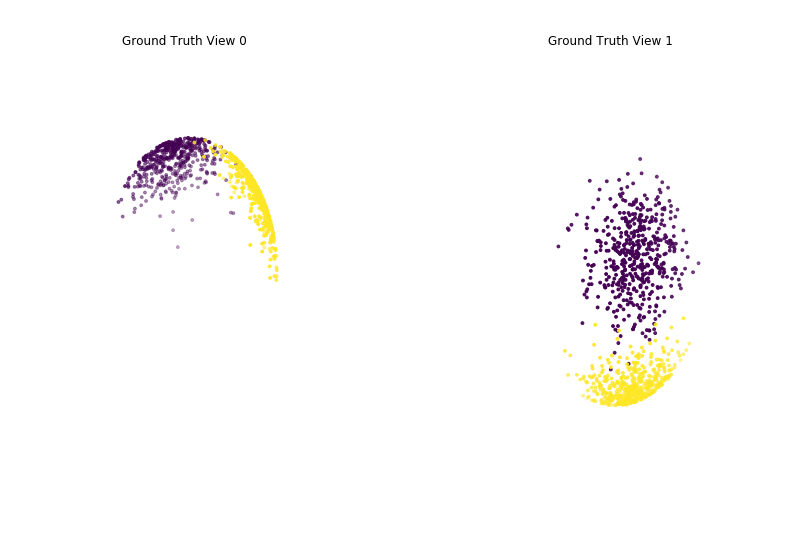

<Figure size 432x288 with 0 Axes>

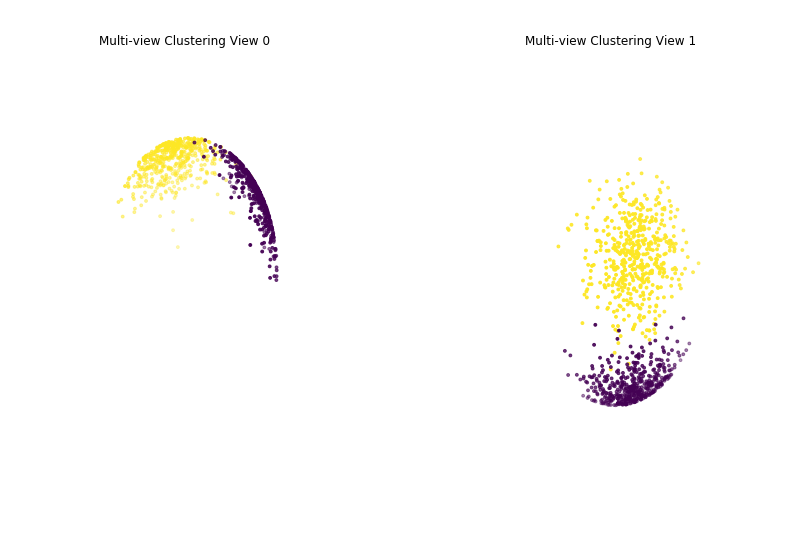

In [21]:
RANDOM_SEED=10

v1_kappas = [15, 15]
v2_kappas = [15, 15]
kappas = [v1_kappas, v2_kappas]
v1_mus = np.array([[-1, 1, 1],[1, 1, 1]])
v1_mus = normalize(v1_mus)
v2_mus = np.array([[1, -1, 1],[1, -1, -1]])
v2_mus = normalize(v2_mus)
v_means = [v1_mus, v2_mus]
data, labels = create_data(RANDOM_SEED, v_means, kappas)

m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are relatively inseparable (highly overlapping) in both views

As we can see, multi-view spherical kmeans clustering performs about as poorly as single-view spherical kmeans clustering across both individual views and concatenated views as inputs.

Single-view View 1 NMI Score: 0.102

Single-view View 2 NMI Score: 0.112

Single-view Concatenated NMI Score: 0.199

Multi-view NMI Score: 0.204



<Figure size 432x288 with 0 Axes>

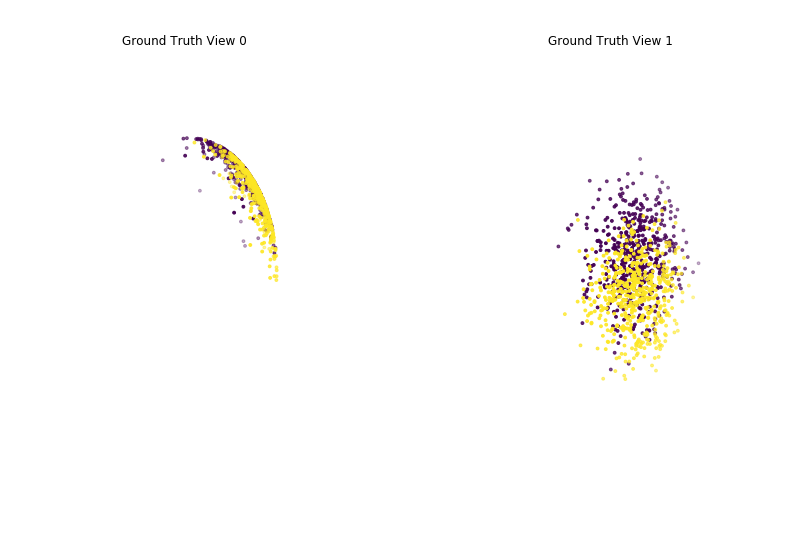

<Figure size 432x288 with 0 Axes>

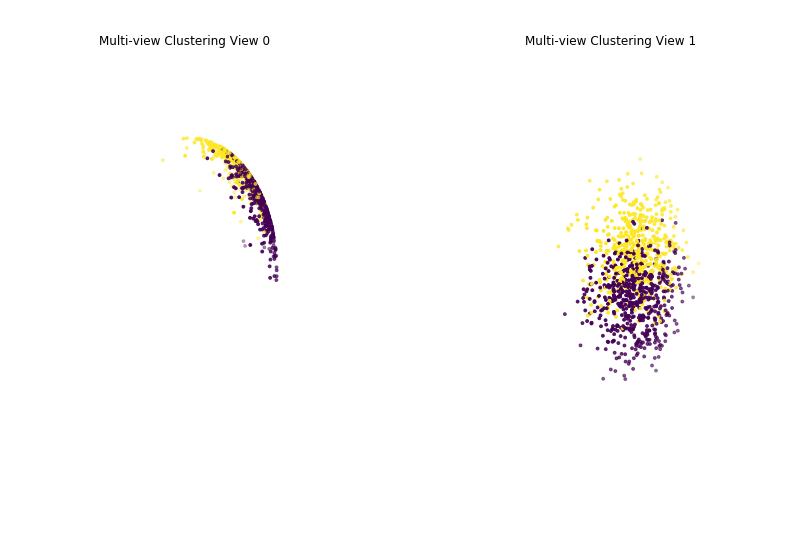

In [22]:
v1_kappas = [15, 15]
v2_kappas = [15, 15]
kappas = [v1_kappas, v2_kappas]
v1_mus = np.array([[0.5, 1, 1],[1, 1, 1]])
v1_mus = normalize(v1_mus)
v2_mus = np.array([[1, -1, 1],[1, -1, 0.5]])
v2_mus = normalize(v2_mus)
v_means = [v1_mus, v2_mus]
data, labels = create_data(RANDOM_SEED, v_means, kappas)

m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are somewhat separable (somewhat overlapping) in both views

Again we can see that multi-view spherical kmeans clustering performs about as well as single-view spherical kmeans clustering for the concatenated views, and both of these perform better than on single-view spherical kmeans clustering for just one view. 

Single-view View 1 NMI Score: 0.677

Single-view View 2 NMI Score: 0.552

Single-view Concatenated NMI Score: 0.827

Multi-view NMI Score: 0.821



<Figure size 432x288 with 0 Axes>

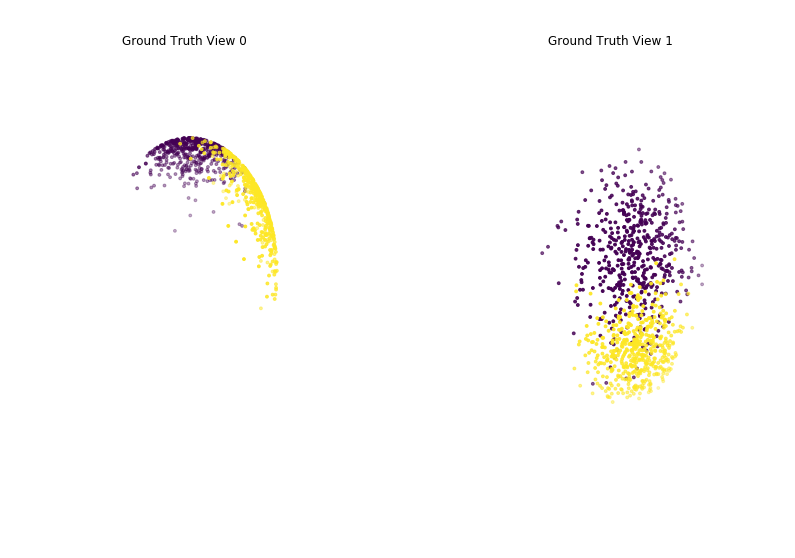

<Figure size 432x288 with 0 Axes>

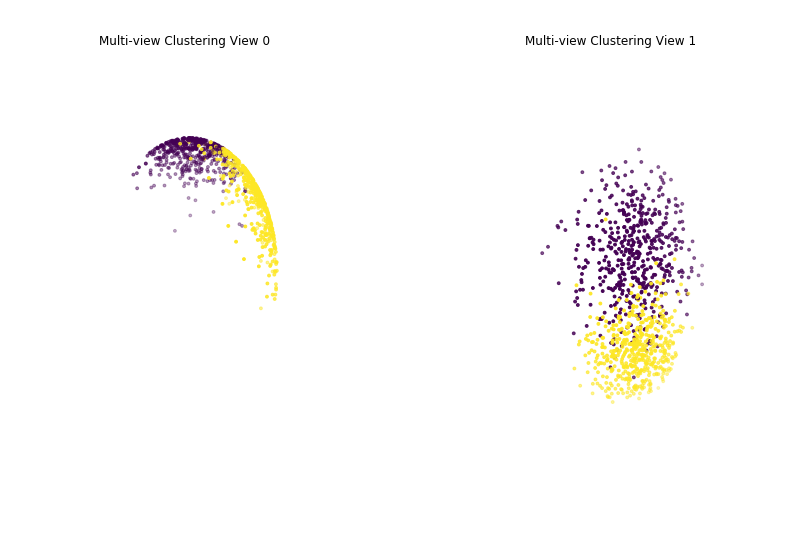

In [23]:
v1_kappas = [15, 10]
v2_kappas = [10, 15]
kappas = [v1_kappas, v2_kappas]
v1_mus = np.array([[-0.5, 1, 1],[1, 1, 1]])
v1_mus = normalize(v1_mus)
v2_mus = np.array([[1, -1, 1],[1, -1, -0.2]])
v2_mus = normalize(v2_mus)
v_means = [v1_mus, v2_mus]
data, labels = create_data(RANDOM_SEED, v_means, kappas)

m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are highly overlapping in one view

As we can see, multi-view spherical kmeans clustering performs worse than single-view spherical kmeans clustering with concatenated views as inputs and with the best view as the input.

Single-view View 1 NMI Score: 0.740

Single-view View 2 NMI Score: 0.077

Single-view Concatenated NMI Score: 0.768

Multi-view NMI Score: 0.741



<Figure size 432x288 with 0 Axes>

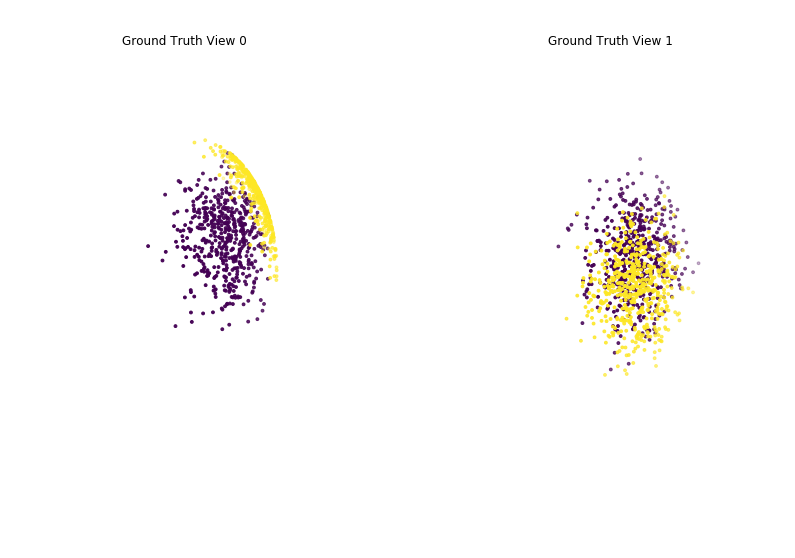

<Figure size 432x288 with 0 Axes>

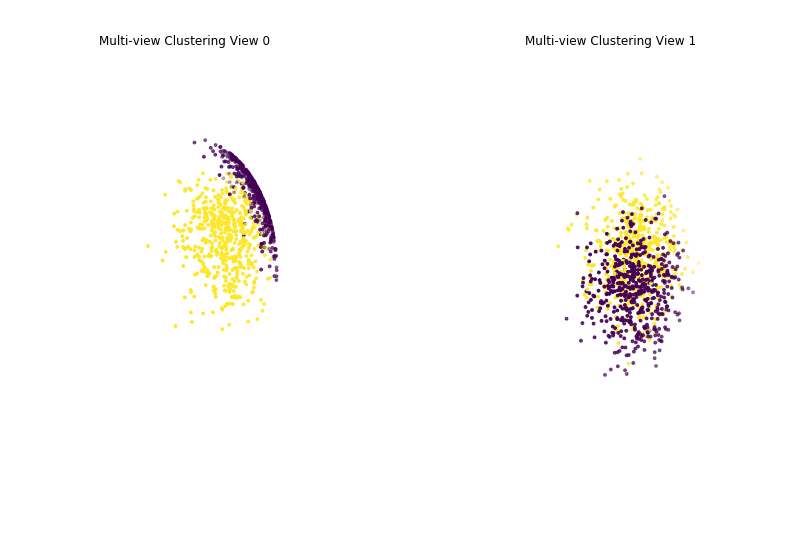

In [24]:
v1_kappas = [15, 15]
v2_kappas = [15, 15]
kappas = [v1_kappas, v2_kappas]
v1_mus = np.array([[1, -0.5, 1],[1, 1, 1]])
v1_mus = normalize(v1_mus)
v2_mus = np.array([[1, -1, 1],[1, -1, 0.6]])
v2_mus = normalize(v2_mus)
v_means = [v1_mus, v2_mus]
data, labels = create_data(RANDOM_SEED, v_means, kappas)

m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Conclusions

Here, we have seen some of the limitations of multi-view spherical kmeans clustering. From the experiments above, it is apparent that multi-view spherical kmeans clustering performs equally as well or worse than single-view spherical kmeans clustering on concatenated data when views are informative but the data is fairly simple (i.e. only has 2 features per view). However, it is clear that the multi-view spherical kmeans algorithm does perform better on well separated cluster components than it does on highly overlapping cluster components, which does validate it's basic functionality as a clustering algorithm. 